# r-3379

Taken on March 30th, Krypton run, Krypton trigger with "November 20162 conditions

In [57]:
import datetime

In [58]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-03-24 11:02:45


In [59]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from invisible_cities.database import load_db
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.pmaps_functions as pmf

In [62]:
from invisible_cities.reco.pmap_io import pmap_writer, S12, S2Si

from   invisible_cities.core.configure import configure, print_configuration

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.cities.base_cities import PmapCity, SensorParams
from   invisible_cities.cities.base_cities import S12Params as S12P

In [63]:
from invisible_cities.core.core_functions import define_window
from invisible_cities.core.core_functions import lrange
from collections import namedtuple

In [64]:
from invisible_cities.reco.params import S12Params, ThresholdParams, CalibratedSum, PMaps,\
                                         SensorParams, CalibParams, PmapParams, CalibratedPMT, S1PMaps

In [65]:
from matplotlib.figure import Figure

In [66]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [67]:
from event_pmaps import compare_S1

### Input

In [68]:
run_number=3379


In [69]:
RWF_file = os.path.join(os.environ['IC_DATA'],
                        'LSC/{}/run_3379.gdc1next.next-new.000.rd_3379.root.h5'.format(run_number))

In [70]:
h5rwf = False

In [71]:
if h5rwf:
    h5rwf.close()

In [72]:
h5rwf = tb.open_file(RWF_file,'r')

In [73]:
h5rwf

File(filename=/Users/alej/Desktop/IC_DATA/LSC/3379/run_3379.gdc1next.next-new.000.rd_3379.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/RD (Group) ''
/RD/pmtblr (EArray(82, 12, 52000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/pmtrwf (EArray(82, 12, 52000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/sipmrwf (EArray(82, 1792, 1300), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1300)
/Run (Group) ''
/Run/events (Table(82,)) ''
  description := {
  "evt_number": Int32Col(shape=(), dflt=0, pos=0),
  "timestamp": UInt64Col(shape=(), dflt=0, pos=1)}
  byteorder := 'little'
  chunkshap

### pmtrwf and sipmrwf vectors

To get vectors use **get_vectors(file)** in tbl_functions

In [74]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [75]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 82
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


### Access to data base and definition of units

In [76]:
DataPMT = load_db.DataPMT(run_number)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c = abs(DataPMT.coeff_c.values)
coeff_blr = abs(DataPMT.coeff_blr.values)
DataSiPM = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [77]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,22,PMT1,1,-23.9414,65.7785,0.00080,0.000001,25.39,0.7160,9.474
1,1,18,PMT3,1,-44.9951,-53.6231,0.00080,0.000001,26.49,0.8744,10.510
2,2,23,PMT2,1,68.9365,-12.1554,0.00080,0.000001,27.74,0.7303,9.031
3,3,0,PMT4,1,0.0000,185.0000,0.00161,0.000003,25.17,0.7060,8.720
4,4,31,PMTC,1,-118.9160,141.7180,0.00160,0.000003,26.56,0.7000,8.910
5,5,8,PMTB,1,-182.1890,32.1249,0.00161,0.000003,21.55,0.7278,6.900
6,6,5,PMTA,1,-160.2150,-92.5000,0.00161,0.000003,23.86,0.7323,7.860
7,7,4,PMT9,1,-63.2737,-173.8430,0.00161,0.000003,33.57,0.7206,11.750
8,8,1,PMT8,1,63.2737,-173.8430,0.00162,0.000003,22.15,0.7213,7.070
9,10,27,PMT6,1,182.1890,32.1249,0.00080,0.000001,20.83,0.7921,6.780


In [78]:
def _calib_vectors(self):
        """Provisional fix for calib vectors"""
        channel_id = np.array([0,1,4,5,8,18,22,23,26,27,30])
        coeff_blr = np.array([1.61,1.62,1.61,1.61,1.61,
                          0.8,0.8,0.8,0.8,0.8,1.60,
                          1.0]) * 0.001
        coeff_c = np.array([2.94,2.75,3.09,2.81,2.88,
                        1.,1.,1.,1.,1.,2.76,
                        1.0]) * 1e-6
        adc_to_pes = np.array([25.17,22.15,33.57,23.88,21.55,
                           26.49,25.39,27.74,23.78,20.83,26.56,
                           0.])
        pmt_active = list(range(11))

        DataSiPM = load_db.DataSiPM()
        self.P   = CalibVectors(channel_id = channel_id,
                                coeff_blr  = coeff_blr,
                                coeff_c    = coeff_c,
                                adc_to_pes_pmt = adc_to_pes,
                                adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                                pmt_active  = pmt_active)

### PMT multiplicity


In [139]:
pmt_mult = {}
energies = []
s1_count = 0 

for event in range(NEVT):
    RWF = pmtrwf[event]
    CWF = blr.deconv_pmt(RWF,
                         coeff_c,
                         coeff_blr,
                         pmt_active,
                         n_baseline  = 48000,
                         thr_trigger = 5)
    
    CAL_PMT, CAL_PMT_MAU    =  cpf.calibrated_pmt_mau(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =  3)
    
    csum, csum_mau = cpf.calibrated_pmt_sum(CWF,adc_to_pes, pmt_active)
        
    s1par = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=6, lmax=40, stride=10, rebin=False)
    
    s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=0.5)
    
    S1 = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())

    ## for each S1
    for sone in S1:
        
        pmt_mult[s1_count] = np.zeros((len(pmt_active),), dtype=np.float32)
        energies.append(S1[sone][1].sum())
        
        ## for each PMT
        for pmt in pmt_active:
            
            # Get the indicies of the S1 in the csum_mau (hopefully)
            ind_S1 = np.array(np.round(S1[sone][0] / 25), dtype=np.int64)
        
            # Check if pmt responded during this 'S1'
            if (CAL_PMT_MAU[pmt, ind_S1] >= 0).any():
                
                ## remember which pmts responded, and how much
                
                pmt_mult[s1_count][pmt] = np.sum(CAL_PMT_MAU[pmt, ind_S1])
                
                
                if pmt_mult[s1_count][pmt] < 0:
                    print(event, pmt, sone, s1_count)
                    break
                
        s1_count += 1

    
    

In [122]:
mult   = np.zeros((len(pmt_mult)), dtype=np.int8)
for s1 in pmt_mult:
    mult  [s1] = len(pmt_mult[s1].nonzero()[0])
    
    


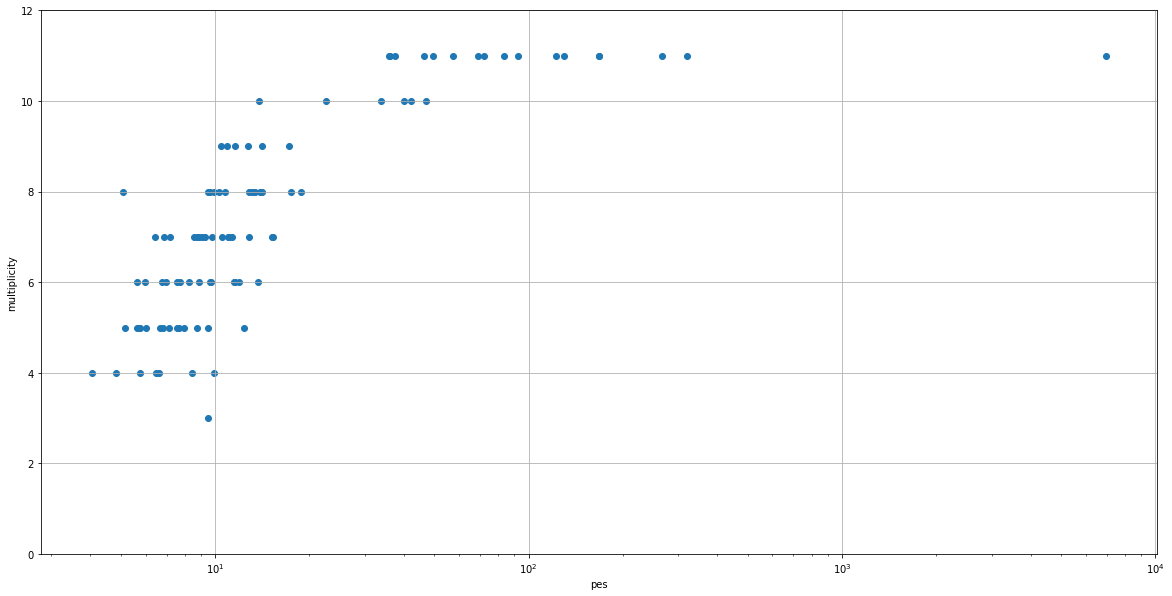

In [140]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()


plt.scatter(energies, mult)
plt.ylim(0,12)
#plt.xlim(0,500)
plt.xlabel('pes')
plt.ylabel('multiplicity')
plt.grid(True)
ax.set_xscale('log')

plt.show()

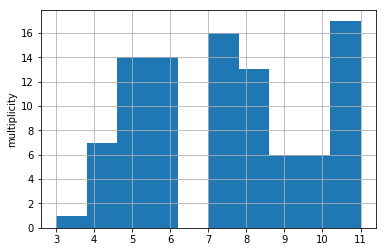

In [128]:
plt.hist(mult)
plt.grid(True)
plt.ylabel('multiplicity')
plt.show()

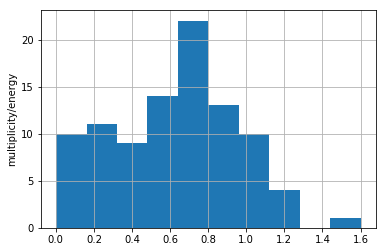

In [132]:
plt.hist(mult / energy)
plt.grid(True)
plt.ylabel('multiplicity/energy')
plt.show()

### RWF

In [23]:
event=0
RWF = pmtrwf[event]

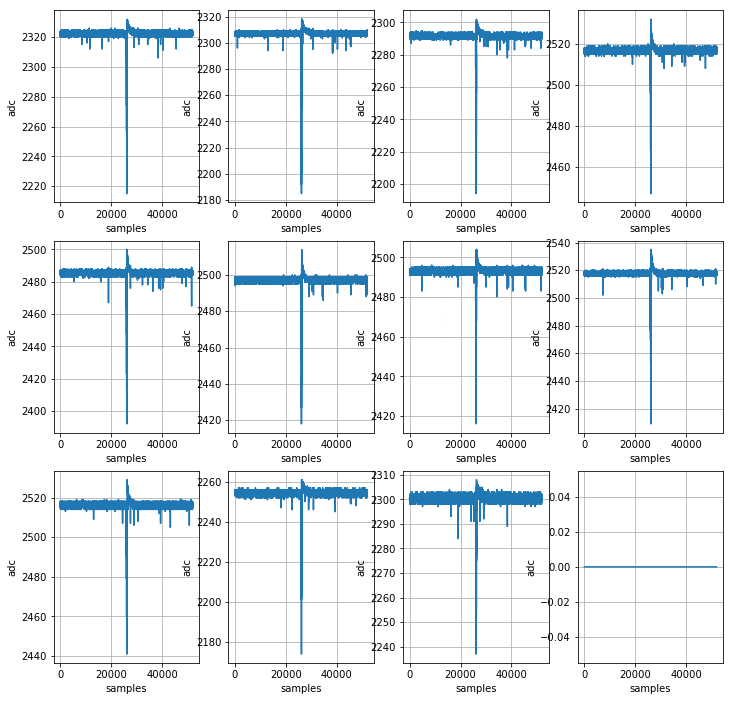

In [24]:
wfm.plot_pmt_waveforms(RWF, zoom=False, window_size=10000)

In [25]:
CWF = blr.deconv_pmt(RWF,
                             coeff_c,
                             coeff_blr,
                             pmt_active,
                             n_baseline  = 48000,
                             thr_trigger = 5)

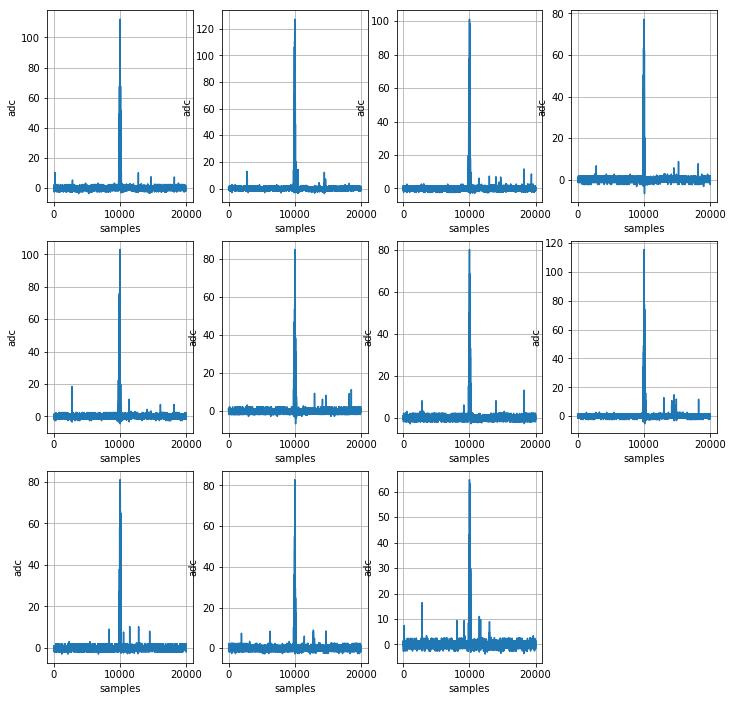

In [26]:
wfm.plot_pmt_waveforms(CWF, zoom=True, window_size=10000)

In [27]:
CAL_PMT, CAL_PMT_MAU    =    cpf.calibrated_pmt_mau(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =  3)

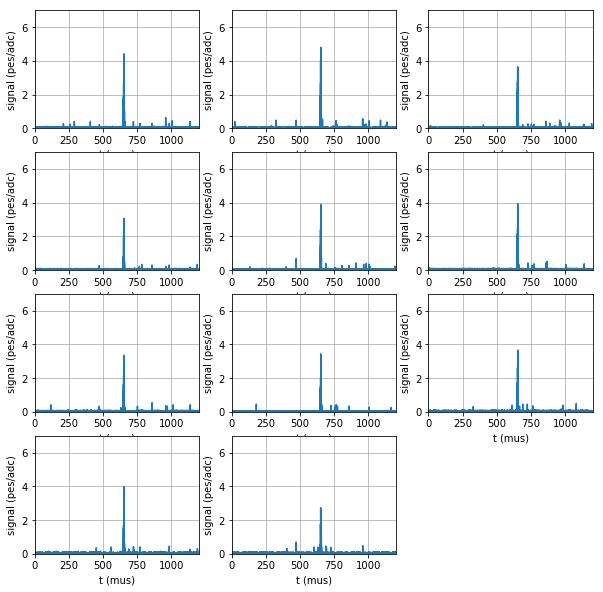

In [28]:
mpl.plot_pmt_signals_vs_time_mus(CAL_PMT,
                             pmt_active = pmt_active,
                             t_min      = 0,
                             t_max      = 1200,
                             signal_min =    0,
                             signal_max =  7)

In [29]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,adc_to_pes, pmt_active)

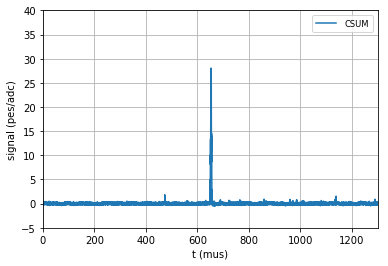

In [30]:
mpl.plot_signal_vs_time_mus(csum, t_min=0, t_max=1300, signal_min=-5, signal_max=40, label='CSUM')

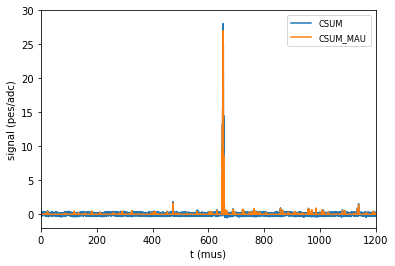

In [31]:
mpl.plot_calibrated_sum_in_mus(CalibratedSum(csum=csum, csum_mau=csum_mau), 
                               tmin=0, tmax=1200, signal_min=-2, signal_max=30, 
                               csum=True, csum_mau=True)

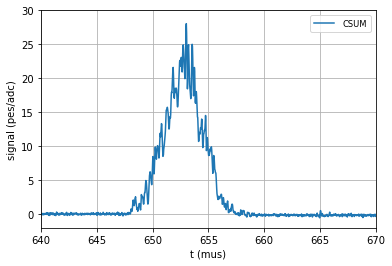

In [32]:
mpl.plot_signal_vs_time_mus(csum, t_min=640, t_max=670, signal_min=-2, signal_max=30, label='CSUM')

### s12 searches

In [33]:
s1par = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=6, lmax=40, stride=10, rebin=False)

In [34]:
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=0.5)
S1 =  cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())

In [35]:
S1

{0: [array([ 472875.,  472900.,  472925.,  472950.,  472975.,  473000.,
          473025.,  473050.,  473075.]),
  array([ 0.56806537,  1.26782153,  1.51689607,  1.63097451,  1.33720369,
          1.04050893,  0.88121308,  0.69245317,  0.54282814])]}

number of peaks = 1
S12 number = 0, samples = 9 sum in pes =9.477964490464243


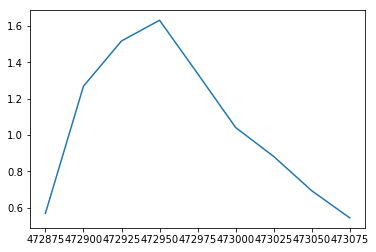

In [36]:
pmf.scan_s12(S1)

In [37]:
plot_s12(S1)

NameError: name 'plot_s12' is not defined

In [38]:
s1par_PMT = S12Params(tmin=471*units.mus, tmax=474*units.mus, lmin=3, lmax=30, stride=4, rebin=False)

In [39]:
PMT_S1 = {}
    
for pmt in pmt_active:
    s1_ene, s1_indx = cpf.wfzs(CAL_PMT_MAU[pmt], threshold=0.1)
    PMT_S1[pmt] = cpf.find_S12(s1_ene, s1_indx, **s1par_PMT._asdict())

In [40]:
PMT_S1

{0: {0: [array([ 473500.,  473525.,  473550.,  473575.]),
   array([ 0.1321958 ,  0.21099783,  0.17176451,  0.17190109])]},
 1: {0: [array([ 472850.,  472875.,  472900.,  472925.,  472950.,  472975.]),
   array([ 0.14763629,  0.29869637,  0.44999483,  0.48811822,  0.41297627,
           0.14894849])],
  1: [array([ 473475.,  473500.,  473525.,  473550.]),
   array([ 0.18669232,  0.26237027,  0.30034324,  0.18728575])]},
 2: {},
 3: {0: [array([ 472950.,  472975.,  473000.,  473025.]),
   array([ 0.1471671 ,  0.22668901,  0.26681323,  0.22747777])]},
 4: {0: [array([ 472950.,  472975.,  473000.,  473025.,  473050.,  473075.,
           473100.,  473125.]),
   array([ 0.12485289,  0.35093517,  0.50221541,  0.65373531,  0.69245317,
           0.54282814,  0.39296345,  0.16749797])]},
 5: {},
 6: {0: [array([ 472900.,  472925.,  472950.,  472975.]),
   array([ 0.2537609 ,  0.33805629,  0.25470709,  0.17122366])],
  1: [array([ 473450.,  473475.,  473500.]),
   array([ 0.1714473 ,  0.213663

In [41]:
compare_S1(S1, PMT_S1)

5

In [42]:
s2_par = S12Params(tmin=640*units.mus, tmax=800*units.mus, stride=40, lmin=80, lmax=20000, rebin=True)

In [43]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=0.5)
S2              = cpf.find_S12(s2_ene, s2_indx, **s2_par._asdict())

In [44]:
S2

{0: [array([ 648596.25,  649612.5 ,  650612.5 ,  651612.5 ,  652612.5 ,
          653612.5 ,  654612.5 ,  655612.5 ,  656671.25,  658087.5 ]),
  array([  60.25052003,  170.80070047,  392.46770073,  651.31760663,
          858.81541611,  763.11125483,  456.6183173 ,  232.19182516,
           58.21636512,    2.1475456 ])]}

In [45]:
def plot_s12(S12):
    """Plot the peaks of input S12.

    S12 is a dictionary
    S12[i] for i in keys() are the S12 peaks
    """
    plt.figure(figsize=(10, 10))
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "S12 (pes)")
    xy = len(S12)
    if xy == 1:
        t = S12[0][0]
        E = S12[0][1]
        ax1 = plt.subplot(1, 1, 1)
        plt.plot(t, E)
    else:
        x = 3
        y = xy/x
        if y % xy != 0:
            y = int(xy/x) + 1
        for i in S12.keys():
            ax1 =  plt.subplot(x, y, i+1)
            t = S12[i][0]
            E = S12[i][1]
            plt.plot(t, E)


number of peaks = 1
S12 number = 0, samples = 10 sum in pes =3645.937251959334


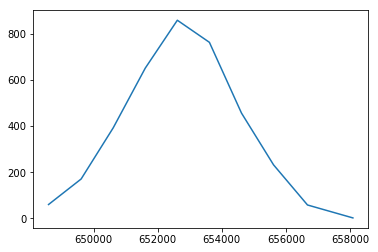

In [46]:
pmf.scan_s12(S2)

In [47]:
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=3.5*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
S2Si = pf.sipm_s2_dict(SIPM, S2, thr=5*units.pes)

In [48]:
S2Si

{0: {389: array([  0.        ,   0.        ,   0.        ,  10.25730184,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ]),
  397: array([  4.76348713,   7.48270893,  10.07832975,   6.98830497,
           6.24669902,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ]),
  398: array([ 0.        ,  0.        ,  5.26977523,  8.29088602,  3.97501347,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
  405: array([ 0.        ,  0.        ,  3.60359377,  4.28218305,  4.52894278,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
  406: array([ 0.        ,  0.        ,  5.16795316,  4.26781107,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ])}}

In [49]:
len(S2Si)

1

In [50]:
def charge_and_position(s2si):
        """
        Charge and position from S2Si
        """
        xsipm = []
        ysipm = []
        Q = []
        
        for key, value in s2si.items():
            xsipm.append(xs[key])
            ysipm.append(ys[key])
            Q.append(np.sum(value))
        return np.array(xsipm), np.array(ysipm), np.array(Q)

In [51]:
xsipm, ysipm, Q = charge_and_position(S2Si[0])

In [52]:
X    = np.average(xsipm, weights=Q) if np.any(Q) else np.nan
Y    = np.average(ysipm, weights=Q) if np.any(Q) else np.nan
R    = (X**2 + Y**2)**0.5 if np.any(Q) else np.nan
Phi  = np.arctan2(Y, X) if np.any(Q) else np.nan

In [53]:
print(X,Y,R,Phi)

-143.639345643 -61.8344492504 156.383377412 -2.73508613982


In [55]:
def plot_s2si_map(S2Si, cmap='Blues'):
        """Plot a map of the energies of S2Si objects."""
        from   invisible_cities.core.mpl_functions import circles

        DataSensor = load_db.DataSiPM()
        radius = 3
        xs = DataSensor.X.values
        ys = DataSensor.Y.values
        r = np.ones(len(xs)) * radius
        col = np.zeros(len(xs))
        for sipm in S2Si.values():
            for nsipm, E in sipm.items():
                ene = np.sum(E)
                col[nsipm] = ene
        plt.figure(figsize=(8, 8))
        plt.subplot(aspect="equal")
        circles(xs, ys, r, c=col, alpha=0.5, ec="none", cmap=cmap)
        plt.colorbar()

        plt.xlim(-198, 198)
        plt.ylim(-198, 198)

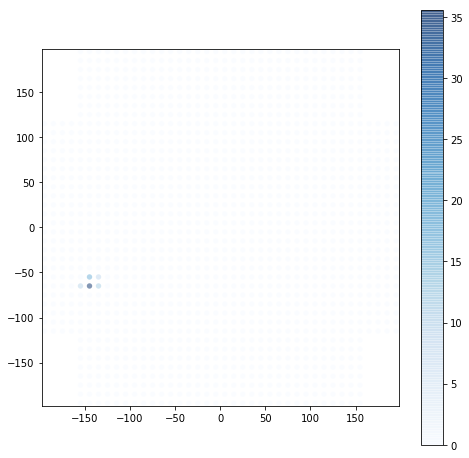

In [56]:
plot_s2si_map(S2Si)